In [3]:
!pip install catboost
!pip install hyperopt
!pip install -U pandas
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 752.3 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.8 MB/s eta 0:00:00:00:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 46.9 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autovizwidget 0.21.0 requires pandas<2.0.0,>=0.20.1, but you have pandas 2.1.4 which is incompatible.
hdijupyterutils 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.1.4 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.1.4 which is incompatible.


In [1]:
!wget https://gist.githubusercontent.com/garkavem/2613ca62c9ace338b217eccc99fe1f6f/raw/981dae5111bb2a30e20dca888a99020d5c4f5899/gistfile1.txt -O cars.csv

--2024-01-14 00:30:16--  https://gist.githubusercontent.com/garkavem/2613ca62c9ace338b217eccc99fe1f6f/raw/981dae5111bb2a30e20dca888a99020d5c4f5899/gistfile1.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7542506 (7.2M) [text/plain]
Saving to: ‘cars.csv’

100%[======================================>] 7,542,506   --.-K/s   in 0.03s   

2024-01-14 00:30:16 (218 MB/s) - ‘cars.csv’ saved [7542506/7542506]



In [5]:
import pandas as pd
from catboost import CatBoost, CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve,auc
import numpy as np
import catboost

df = pd.read_csv("cars.csv")

In [6]:
categorical_features_names = ['manufacturer_name', 'model_name', 'transmission', 'color', 'engine_fuel',
                              'engine_type',  'body_type',  'state', 'drivetrain','location_region']

target = 'price_usd'
continous_features_names = ['odometer_value', 'year_produced', 'engine_has_gas', 'engine_capacity', 'has_warranty', 'is_exchangeable', 
             'number_of_photos', 'up_counter', 'duration_listed']

predict_columns = categorical_features_names + continous_features_names

df = df[predict_columns+[target]]
df[target] = np.where(df[target] > 5000,1,0)

In [7]:
train, test = train_test_split(df, test_size=0.3, random_state=42)
test, valid = train_test_split(df, test_size=0.5, random_state=42)

train_pool = Pool(train[predict_columns], 
                  label=train[target],
                  cat_features=categorical_features_names)

test_pool = Pool(test[predict_columns], 
                  label=test[target],
                  cat_features=categorical_features_names)

valid_pool = Pool(valid[predict_columns], 
                  label=valid[target],
                  cat_features=categorical_features_names)

In [8]:
from scipy import stats

basic_params = {
           'use_best_model':True,
           'loss_function': 'Logloss',
            'eval_metric':'Logloss',
#            'verbose':False,
            'bootstrap_type':"Bernoulli" # in case of categorical features
            'iterations':500,
#            'auto_class_weights':'Balanced',
#              'class_weights':weights_l,
#              'rsm':0.1,  # in case of more than 100 features
#             'max_ctr_complexity':2,
#           'random_state': 45
        }

from hyperopt import hp, fmin, tpe
import numpy as np

def hyperopt_objective(params):
    print(params)
    params.update(basic_params) # add basic parameters

    model = CatBoostClassifier(**params, random_seed=42)
    model.fit(train_pool, verbose=0, eval_set=valid_pool,early_stopping_rounds=10)
    y_pred = model.predict_proba(valid_pool)
    return -average_precision_score(valid_pool.get_label(), y_pred[:,1])

space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'depth': hp.randint('depth', 3, 10),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 100),
    'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
}

best = fmin(hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=5,
    rstate=np.random.default_rng(123))


best.update(basic_params)
best['boosting_type'] = 'Plain' if best['boosting_type'] == 1 else 'Ordered'

{'boosting_type': 'Ordered', 'depth': 6, 'l2_leaf_reg': 6.261725908047229, 'learning_rate': 0.08229158668674165}
{'boosting_type': 'Plain', 'depth': 5, 'l2_leaf_reg': 14.57536538956889, 'learning_rate': 0.15396784221502846}
{'boosting_type': 'Ordered', 'depth': 7, 'l2_leaf_reg': 88.64408099832049, 'learning_rate': 0.011852667441065452}
{'boosting_type': 'Ordered', 'depth': 4, 'l2_leaf_reg': 4.395553569902299, 'learning_rate': 0.17895209625022154}
{'boosting_type': 'Plain', 'depth': 5, 'l2_leaf_reg': 46.82509746065759, 'learning_rate': 0.02385852084914917}
100%|██████████| 5/5 [03:35<00:00, 43.08s/trial, best loss: -0.9904067799077299]


In [9]:
best

{'boosting_type': 'Plain',
 'depth': 5,
 'l2_leaf_reg': 14.57536538956889,
 'learning_rate': 0.15396784221502846,
 'use_best_model': True,
 'loss_function': 'Logloss',
 'eval_metric': 'Logloss',
 'bootstrap_type': 'Bernoulli'}

In [16]:
model = CatBoostClassifier(**best, random_seed=42)
model.fit(train_pool, verbose=0, eval_set=valid_pool,early_stopping_rounds=10)

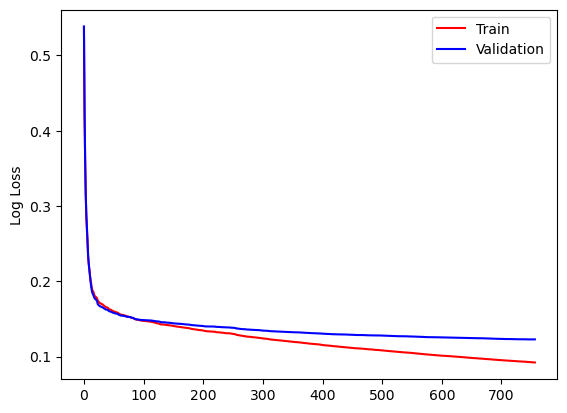

In [22]:
import matplotlib.pyplot as plt

model_loss = model.get_evals_result()

plt.plot(model_loss["learn"]["Logloss"],color = 'red',label="Train")
plt.plot(model_loss["validation"]["Logloss"],color = 'blue',label="Validation")
#plt.legend(["Train","Validation"])
plt.legend()
plt.ylabel("Log Loss")
plt.show()

Text(0.5, 0, 'Recall')

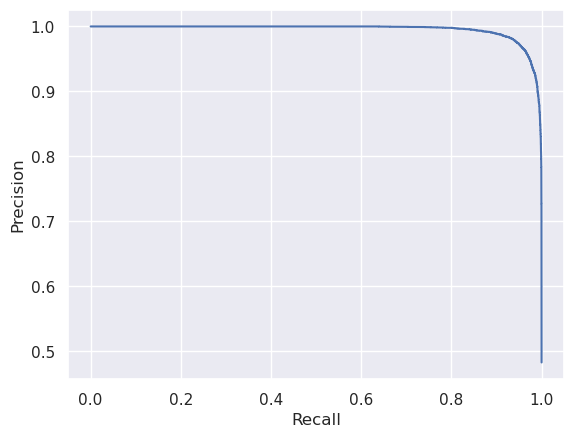

In [34]:
precision, recall, thresholds = precision_recall_curve(test_pool.get_label(),model.predict_proba(test_pool)[:,1])

plt.plot(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")

In [42]:
# Decice treshold
test["pred"] =  model.predict_proba(test_pool)[:,1]

l_ = []
for t in thresholds:
    l_.append(test.loc[test["pred"] >= t].shape[0]/test.shape[0])

treshold_decision = pd.DataFrame({"tresh":thresholds,"precision":precision[0:-1],"recall":recall[0:-1],"reach":l_})

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

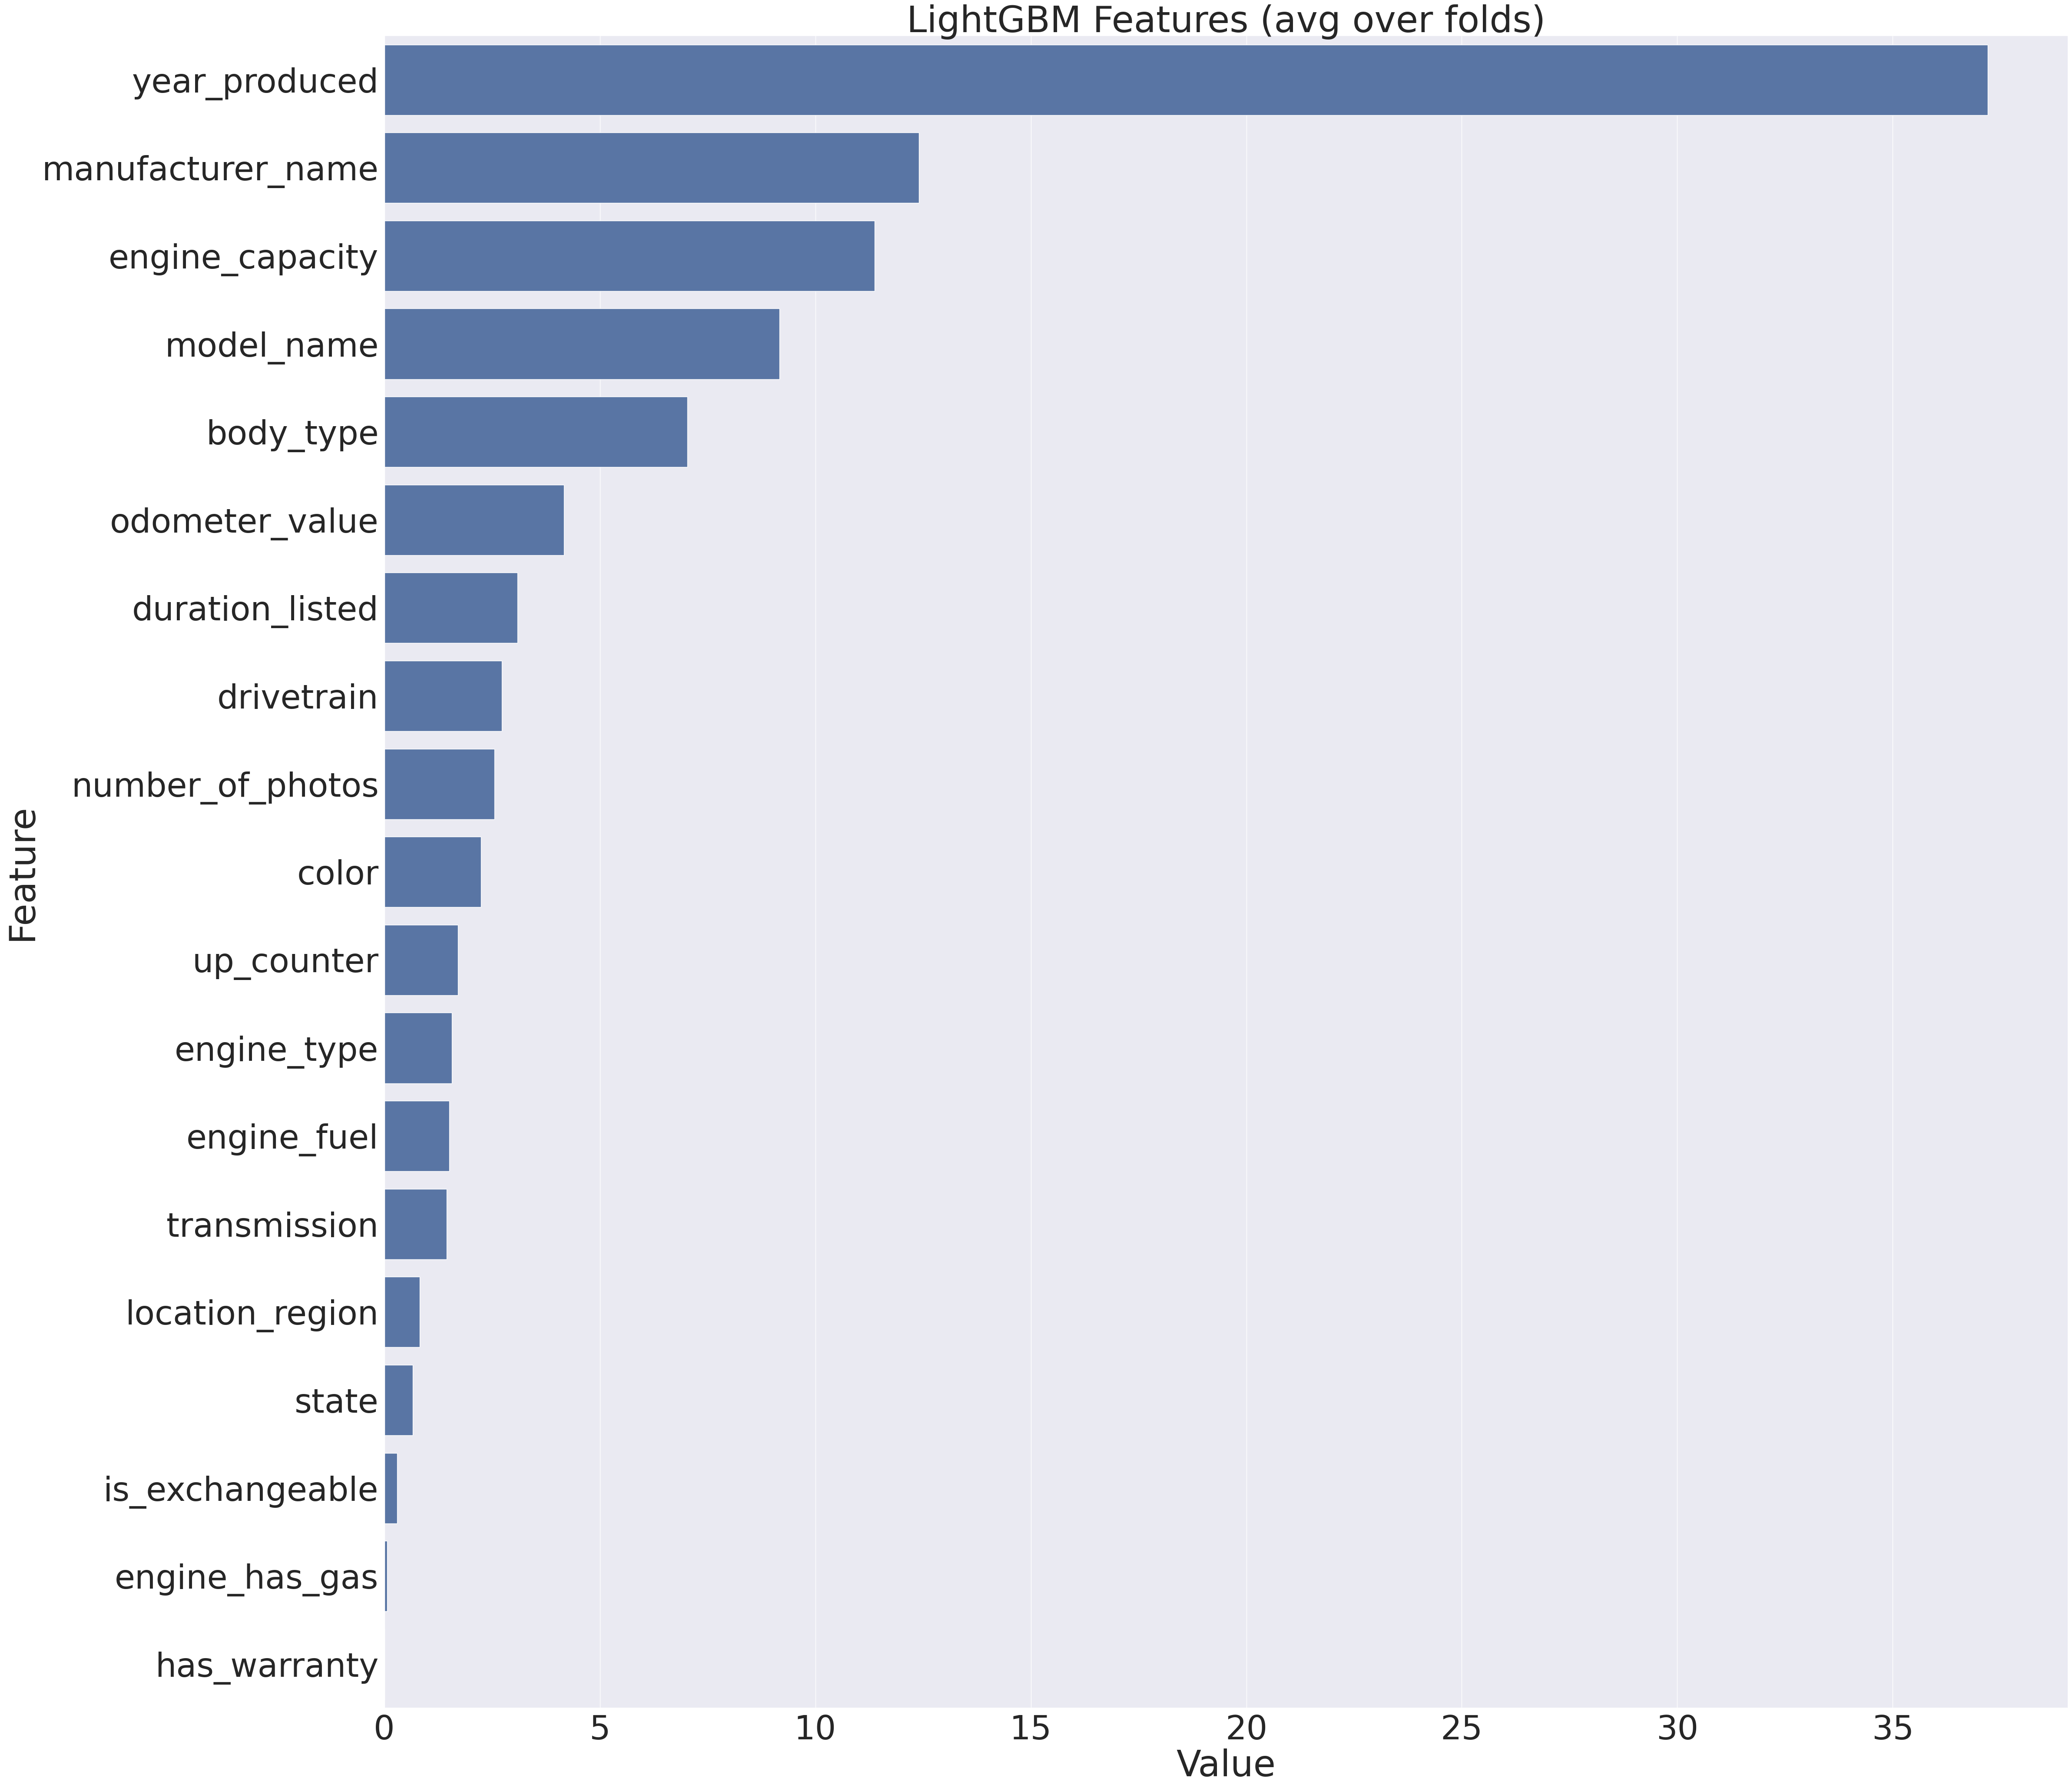

In [28]:
import seaborn as sns

feature_imp = pd.DataFrame(
    list(zip(train_pool.get_feature_names(), model.get_feature_importance(train_pool))), columns=['Feature','Value'])

plt.figure(figsize=(50, 50))
sns.set(font_scale = 5)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:55])
plt.title('Features importance')

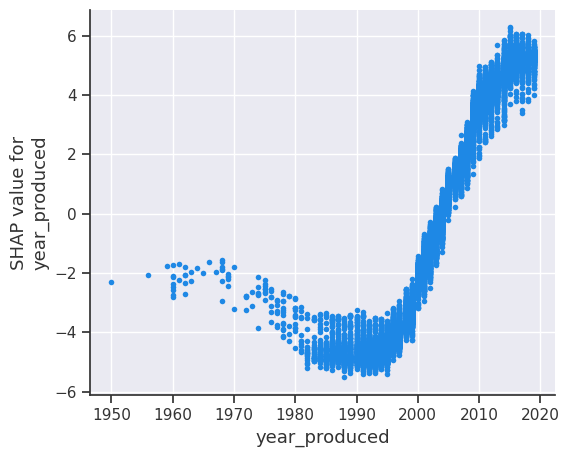

In [51]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(valid_pool)
    
shap.dependence_plot("year_produced", shap_values, valid.drop(target,axis = 1), feature_names=predict_columns, 
                     interaction_index=None
                     #,xmax=40
                    )



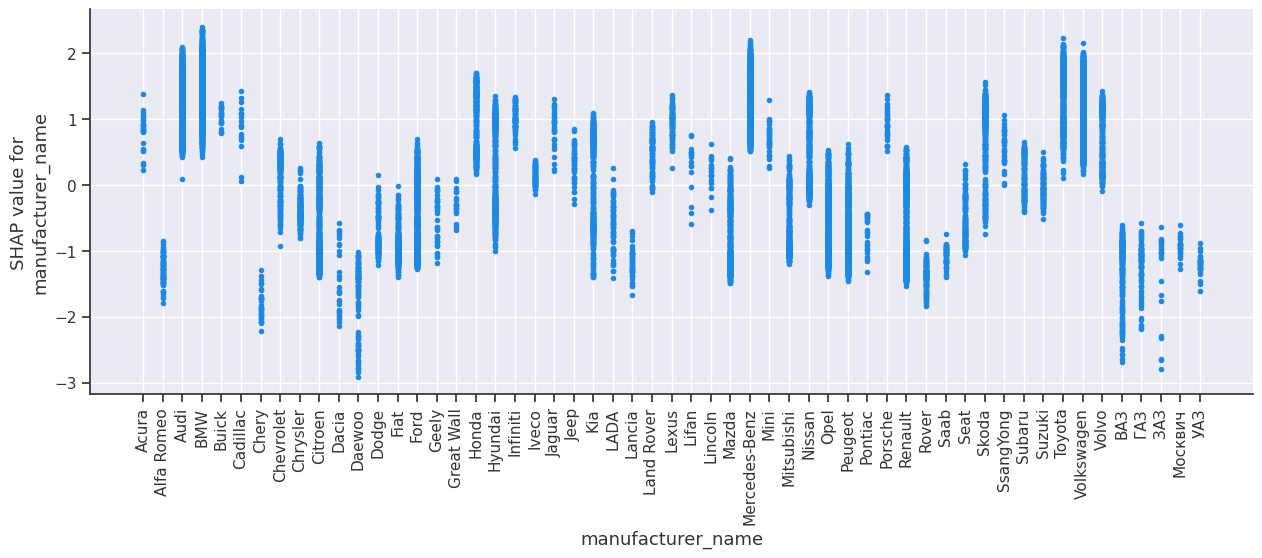

In [55]:
import shap
    
fig, ax = plt.subplots(figsize=(15,5))
shap.dependence_plot("manufacturer_name", shap_values, valid.drop(target,axis = 1), feature_names=predict_columns, 
                     interaction_index=None,ax = ax,
                     #,xmax=40
                    )

